In [3]:
include("/Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2/scripts/intro.jl")
using Graphs
using SimpleWeightedGraphs
using Dice 
using PrettyTables
using LinearAlgebra

using GraphPlot
using Plots
using StatsPlots
using HNProcess
using DataRefine
using PartitioningData
using IterTools
using Random

  Activating 

Currently active project is: HN_V2

Path of active project: /Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2

Have fun with your new project!

You can help us improve DrWatson by opening
issues on GitHub, submitting feature requests,
or even opening your own Pull Requests!



project at `~/Documents/Research Professor/Mikhail Erementchouk/HN_V2`
[ Info: Precompiling HNProcess [top-level] (cache misses: include_dependency fsize change (2))


In [4]:

function unique_random_binary_images(num, cardinality)
    images = []
    i = 0
    if num > cardinality
        print("FAILED")
        return 
    end
    while i < num
        v = rand((-1,1),cardinality)
        if !(v in images)
            push!(images, v)
            i += 1
        end
    end
    return reshape.(images, Int(sqrt(cardinality)), Int(sqrt(cardinality)))
end

unique_random_binary_images(64,256)

64-element Vector{Matrix{Int64}}:
 [-1 1 … -1 -1; 1 -1 … -1 -1; … ; 1 1 … -1 -1; 1 -1 … 1 -1]
 [-1 -1 … 1 1; 1 1 … -1 1; … ; 1 -1 … 1 1; -1 -1 … 1 -1]
 [1 -1 … -1 -1; 1 1 … 1 -1; … ; -1 -1 … -1 1; 1 1 … -1 1]
 [1 1 … 1 -1; -1 1 … 1 1; … ; -1 1 … -1 -1; 1 1 … -1 1]
 [-1 1 … -1 -1; -1 1 … -1 1; … ; -1 -1 … -1 1; 1 -1 … 1 1]
 [-1 1 … 1 1; 1 -1 … -1 1; … ; -1 -1 … 1 -1; 1 -1 … -1 1]
 [-1 -1 … 1 -1; 1 1 … -1 -1; … ; -1 -1 … 1 -1; 1 1 … -1 -1]
 [-1 -1 … 1 -1; -1 -1 … 1 -1; … ; -1 1 … -1 1; -1 -1 … 1 -1]
 [1 -1 … 1 1; -1 -1 … 1 -1; … ; -1 -1 … 1 1; -1 -1 … -1 -1]
 [-1 1 … 1 -1; 1 -1 … 1 1; … ; 1 1 … -1 -1; 1 1 … -1 1]
 [1 -1 … 1 1; -1 -1 … 1 -1; … ; 1 1 … 1 1; -1 1 … 1 1]
 [1 1 … -1 -1; -1 -1 … -1 1; … ; -1 -1 … -1 1; 1 -1 … -1 -1]
 [-1 -1 … -1 -1; -1 -1 … 1 1; … ; 1 1 … -1 -1; -1 1 … 1 -1]
 ⋮
 [-1 -1 … -1 1; 1 1 … -1 1; … ; -1 1 … -1 -1; 1 -1 … -1 1]
 [-1 -1 … 1 -1; 1 -1 … -1 1; … ; 1 -1 … -1 1; -1 -1 … 1 -1]
 [1 1 … -1 1; 1 -1 … -1 1; … ; -1 1 … 1 -1; -1 1 … 1 1]
 [-1 1 … 1 -1; 1 1 … -1 -1;

In [52]:
sim_time = 4
steps = 3000
parameters = Dict{String, Any}(
    "images" => three_random_orthogonal_image(64),
    "sim_time" => sim_time,
    "steps" => steps,
    "iterations" => 100, #Num of times attempted
    "num_agitations" => 1,
    "scaling" => 1.0,
    "delta" => -1* sim_time/steps,
    # This is the region that we will provide and the machine must keep this region constant
    # Will be a vector of tuples which are (row, col, state)
    "initial_stimuli" => [(1,1,1)]
)
println(length(parameters["images"]))

3


In [29]:
parameters["images"] = unique_random_binary_images(4,16)

4-element Vector{Matrix{Int64}}:
 [-1 -1 -1 -1; -1 1 -1 1; -1 -1 -1 -1; -1 1 1 1]
 [1 -1 -1 -1; 1 -1 -1 -1; -1 1 1 1; -1 -1 -1 -1]
 [1 -1 1 1; -1 1 1 1; 1 1 1 -1; -1 -1 1 -1]
 [1 -1 1 -1; -1 1 -1 -1; -1 -1 -1 1; -1 -1 1 -1]

In [33]:
A = zeros(length(parameters["images"]),length(parameters["images"]))
            for i in 1:(length(parameters["images"]))
                for k in i:(length(parameters["images"]))
                    D_ij = (vec(parameters["images"][i])' * vec(parameters["images"][k]))^2
                    A[i,k] = D_ij
                    A[k,i] = D_ij
                end
            end
            res = 1*ones(length(parameters["images"])) # change coeff if precision is not ideal
            lambdas = A \ res
            parameters["scaling"] = lambdas

4-element Vector{Float64}:
 0.0034201954397394137
 0.0034201954397394133
 0.0037459283387622153
 0.0034201954397394137

In [34]:
function objective_func_G_scaled(state, images, lambdas)
    s = 0
    for i in images
        temp = 0 
        temp =  (vec(state)'*vec(i))^2
        s += lambdas[findfirst(x -> x == i, images)] * temp
    end
    return (s * 0.25)
end

objective_func_G_scaled (generic function with 1 method)

In [35]:
for i in 1:length(parameters["images"])
    println("$(i)th image, G value is $(objective_func_G_scaled(parameters["images"][i], parameters["images"], lambdas))")
end

1th image, G value is 0.25
2th image, G value is 0.24999999999999997
3th image, G value is 0.25
4th image, G value is 0.25


# V2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
took 8.989027417 seconds


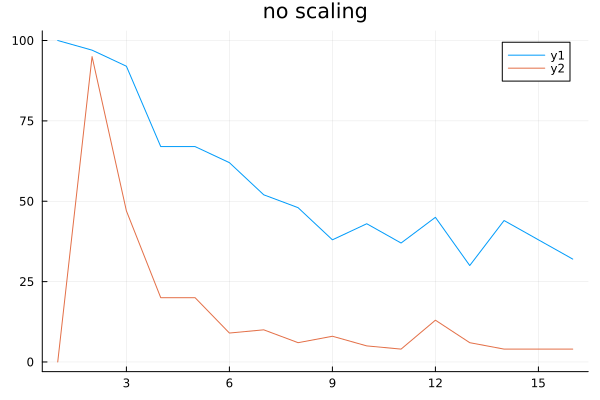

In [47]:
convergences_16 = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => [],
    "multiple_16" => []
)
parameters["scaling"] = 1.0

elp = @elapsed begin
    for p in 1:16
        println(p)
        conv_16 = 0
        twos_16 = 0 
        multi_16 = 0
        for i in 1:100
            parameters["images"] = unique_random_binary_images(p,16)
            r = HN_Solver(parameters)
            sol_count = 0 
            rots = iterative_rotater_state(r,parameters)
            for st in rots
                if (reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                    -1 .*reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                    sol_count +=1 
                end
            end
            if sol_count > 0
                conv_16 += 1
            end
            if sol_count >= 2
                multi_16 += 1 
            end
        end
        push!(convergences_16["image_count"], p)
        push!(convergences_16["conv_16"], conv_16)
        push!(convergences_16["multiple_16"], multi_16)
    end
end

println("took $elp seconds")

plot(convergences_16["image_count"], [convergences_16["conv_16"], convergences_16["multiple_16"]], title = "no scaling")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
took 224.35577325 seconds


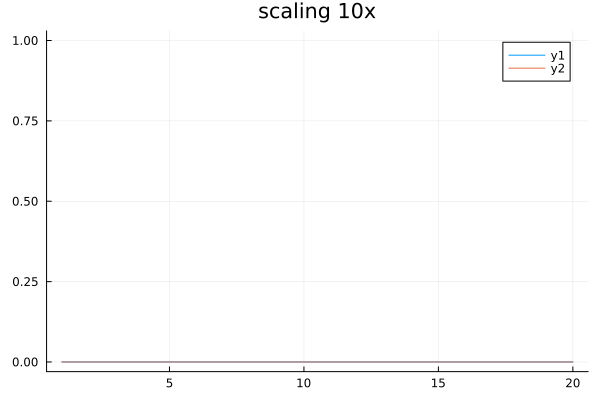

In [54]:
convergences_64 = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => [],
    "multiple_16" => []
)


elp = @elapsed begin
    for p in 1:20
        println(p)
        conv_16 = 0
        twos_16 = 0 
        multi_16 = 0
        for i in 1:100
            parameters["images"] = unique_random_binary_images(p,64)
            #Compute weights
            A = zeros(length(parameters["images"]),length(parameters["images"]))
            for i in 1:(length(parameters["images"]))
                for k in i:(length(parameters["images"]))
                    D_ij = (vec(parameters["images"][i])' * vec(parameters["images"][k]))^2
                    A[i,k] = D_ij
                    A[k,i] = D_ij
                end
            end
            res = 10*ones(length(parameters["images"])) # change coeff if precision is not ideal
            lambdas = A \ res
            parameters["scaling"] = lambdas
            r = HN_Solver(parameters)
            sol_count = 0 
            rots = iterative_rotater_state(r,parameters)
            for st in rots
                if (reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                    -1 .*reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                    sol_count +=1 
                end
            end
            if sol_count > 0
                conv_16 += 1
            end
            if sol_count >= 2
                multi_16 += 1 
            end
        end
        push!(convergences_64["image_count"], p)
        push!(convergences_64["conv_16"], conv_16)
        push!(convergences_64["multiple_16"], multi_16)
    end
end

println("took $elp seconds")

plot(convergences_64["image_count"], [convergences_64["conv_16"], convergences_64["multiple_16"]], title = "scaling 10x")

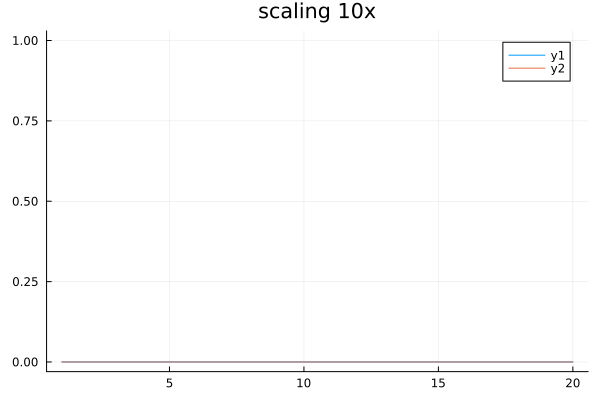

In [51]:
plot(convergences_64["image_count"], [convergences_64["conv_16"], convergences_64["multiple_16"]], title = "scaling 10x")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
took 194.294807083 seconds


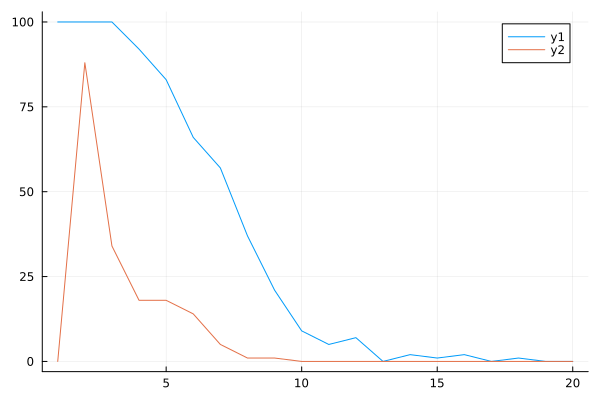

In [26]:
convergences_64 = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => [],
    "multiple_16" => []
)


elp = @elapsed begin
    for p in 1:20
        println(p)
        conv_16 = 0
        twos_16 = 0 
        multi_16 = 0
        for i in 1:100
            parameters["scaling"] = 1.0
            parameters["images"] = unique_random_binary_images(p,64)
            r = HN_Solver(parameters)
            sol_count = 0 
            rots = iterative_rotater_state(r,parameters)
            for st in rots
                if (reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                    -1 .*reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                    sol_count +=1 
                end
            end
            if sol_count > 0
                conv_16 += 1
            end
            if sol_count >= 2
                multi_16 += 1 
            end
        end
        push!(convergences_64["image_count"], p)
        push!(convergences_64["conv_16"], conv_16)
        push!(convergences_64["multiple_16"], multi_16)
    end
end

println("took $elp seconds")

plot(convergences_64["image_count"], [convergences_64["conv_16"], convergences_64["multiple_16"], title = "no weight")

2
took 35.706075917 seconds


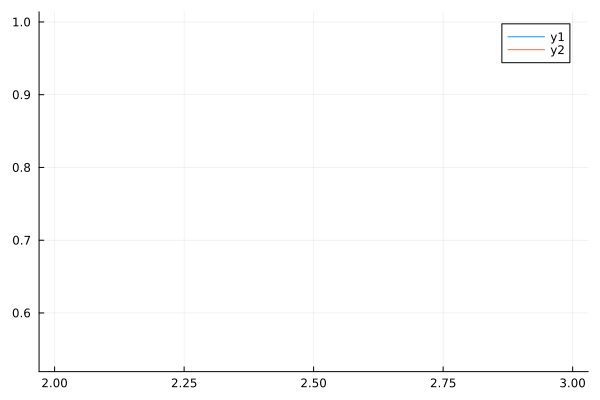

In [9]:
convergences_256 = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => [],
    "multiple_16" => []
)


elp = @elapsed begin
    for p in 2:2
        println(p)
        conv_16 = 0
        twos_16 = 0 
        multi_16 = 0
        for i in 1:30
            parameters["images"] = unique_random_binary_images(p,256)
            r = HN_Solver(parameters)
            sol_count = 0 
            rots = iterative_rotater_state(r,parameters)
            for st in rots
                if (reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                    -1 .*reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                    sol_count +=1 
                end
            end
            if sol_count > 0
                conv_16 += 1
            end
            if sol_count >= 2
                multi_16 += 1 
            end
        end
        push!(convergences_256["image_count"], p)
        push!(convergences_256["conv_16"], conv_16/30)
        push!(convergences_256["multiple_16"], multi_16/30)
    end
end

println("took $elp seconds")

plot(convergences_256["image_count"], [convergences_256["conv_16"], convergences_256["multiple_16"]], marker_shape = "circle")

In [13]:
println(convergences_256["multiple_16"])
k = parameters["images"]
dot(k[1],k[2])

Any[0.5333333333333333]


2

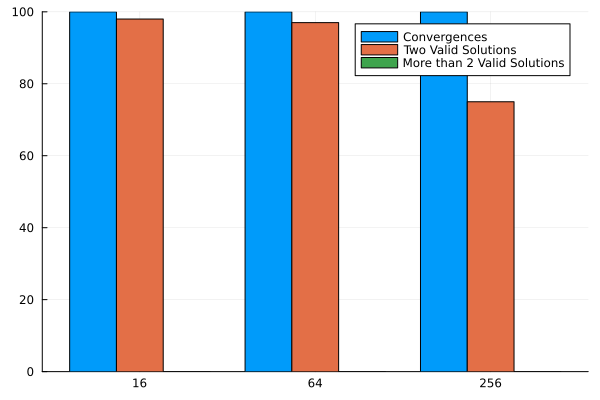

In [23]:
sizes = ["16", "64", "256"]
convs = [conv_16, conv_64, conv_256]
twos = [twos_16, twos_64, twos_256]
others = [others_16, others_64, others_256]

groupedbar(sizes, [convs twos others], bar_position = :dodge,
           labels = ["Convergences" "Two Valid Solutions" "More than 2 Valid Solutions"])

# HN OG

took 6.610878083 seconds


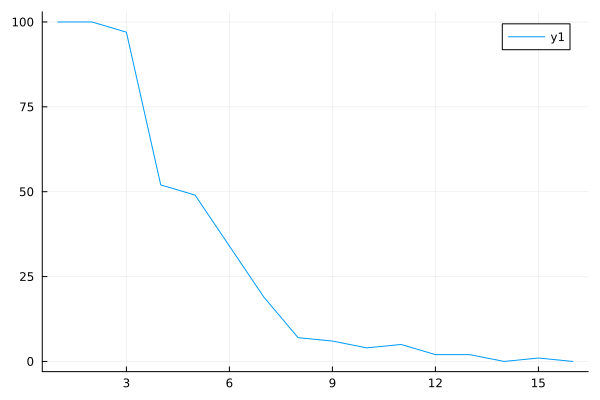

In [40]:
convergences_16_hn = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => []
)
elp = @elapsed begin
    for p in 1:16
        hn_conv_16 =0 
        for i in 1:100
            parameters["images"] = unique_random_binary_images(p,16)
            r = HN_Solver(parameters)
            if (reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                -1 .*reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                hn_conv_16 +=1 
            end
        end
        push!(convergences_16_hn["image_count"], p)
        push!(convergences_16_hn["conv_16"], hn_conv_16)
    end
end
println("took $elp seconds")

plot(convergences_16_hn["image_count"], [convergences_16_hn["conv_16"]])

In [ ]:
image_set = orthogonal_image_generator(64)
convergences_64_hn = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => []
)
elp = @elapsed begin
    for p in 1:64
        hn_conv_16 =0 
        for i in 1:100
            parameters["images"] = unique_random_binary_images(p,64)
            r = HN_Solver(parameters)
            if (reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                -1 .*reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                hn_conv_16 +=1 
            end
        end
        push!(convergences_64_hn["image_count"], p)
        push!(convergences_64_hn["conv_16"], hn_conv_16)
    end
end
println("took $elp seconds")

plot(convergences_64_hn["image_count"], [convergences_64_hn["conv_16"]])

In [29]:
image_set = orthogonal_image_generator(256)
convergences_256_hn = Dict{String, Any}(
    "image_count" => [],
    "conv_16" => []
)
elp = @elapsed begin
    for p in 1:256
        hn_conv_16 =0 
        for i in 1:100
            parameters["images"] = unique_random_binary_images(p,256)
            r = HN_Solver(parameters)
            if (reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
                -1 .*reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                hn_conv_16 +=1 
            end
        end
        push!(convergences_256_hn["image_count"], p)
        push!(convergences_256_hn["conv_16"], hn_conv_16)
    end
end
println("took $elp seconds")

plot(convergences_256_hn["image_count"], [convergences_256_hn["conv_16"]])

83
took 199.903060958 seconds


┌ Warning: Keyword argument bar_position not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, 

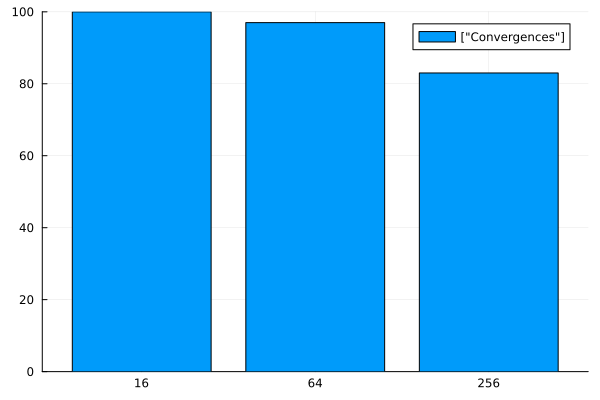

In [32]:
sizes = ["16", "64", "256"]
convs = [hn_conv_16, hn_conv_64, hn_conv_256]

bar(sizes, convs, bar_position = :dodge,
           labels = ["Convergences"])